# **Von Heijne method implementation**

In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.metrics import precision_recall_curve, confusion_matrix
import sklearn.metrics as skl

In [ ]:
# Retrieve the aminoacid frequences from SwissProt
swiss_freq = {
    'A': 8.25, 'Q': 3.93, 'L': 9.64, 'S': 6.65,
    'R': 5.52, 'E': 6.71, 'K': 5.79, 'T': 5.36,
    'N': 4.06, 'G': 7.07, 'M': 2.41, 'W': 1.10,
    'D': 5.46, 'H': 2.27, 'F': 3.86, 'Y': 2.92,
    'C': 1.38, 'I': 5.90, 'P': 4.74, 'V': 6.85
}

swiss_freq = {k: v / 100 for k, v in swiss_freq.items()}

In [ ]:
print(swiss_freq)

{'A': 0.0825, 'Q': 0.0393, 'L': 0.0964, 'S': 0.0665, 'R': 0.0552, 'E': 0.06709999999999999, 'K': 0.0579, 'T': 0.0536, 'N': 0.0406, 'G': 0.0707, 'M': 0.0241, 'W': 0.011000000000000001, 'D': 0.0546, 'H': 0.0227, 'F': 0.038599999999999995, 'Y': 0.0292, 'C': 0.0138, 'I': 0.059000000000000004, 'P': 0.047400000000000005, 'V': 0.06849999999999999}


In [ ]:
def fasta_to_dataframe(fasta_file, second_fasta):
  ''' Function that converts a fasta file into a dataframe with id and sequence'''
  records = SeqIO.parse(fasta_file, "fasta")
  records2 = SeqIO.parse(second_fasta, "fasta")
  data = {
      "id": [],
      "sequence": []
  }
  for record in records:
      data["id"].append(record.id)
      data["sequence"].append(str(record.seq))
  for record in records2:
      data["id"].append(record.id)
      data["sequence"].append(str(record.seq))
  seqs_df = pd.DataFrame(data)
  return seqs_df

# Convert fasta format sequences into a pandas dataframe
seqs_df = fasta_to_dataframe("cluster-results-neg_rep_seq.fasta", "cluster-results_rep_seq.fasta")
seqs_df.head()

,id,sequence
0,P41252,MLQQVPENINFPAEEEKILEFWTEFNCFQECLKQSKHKPKFTFYDG...
1,Q01064,MELSPRSPPEMLEESDCPSPLELKSAPSKKMWIKLRSLLRYMVKQL...
2,Q0IIM8,MWLKPEEVLLKNALKLWLMERSNDYFVLQRRRGYGEEGGGGLTGLL...
3,Q0VDF9,MAAIGVHLGCTSACVAVYKDGRAGVVANDAGDRVTPAVVAYSENEE...
4,Q5VWZ2,MAAASGSVLQRCIVSPAGRHSASLIFLHGSGDSGQGLRMWIKQVLN...


In [ ]:
# Convert a tsv file into a pandas dataframe
cols = ["id", "organism_name", "kingdom","seq_len","SP","validation_n", "sp_type"]
training_df = pd.read_csv("training_set.tsv", sep="\t", names= cols)
training_df.head()

,id,organism_name,kingdom,seq_len,SP,validation_n,sp_type
0,Q99MA2,Rattus norvegicus,Metazoa,674,22,3,1
1,P17948,Homo sapiens,Metazoa,1338,26,1,1
2,P41271,Homo sapiens,Metazoa,181,16,1,1
3,Q8I948,Acanthoscurria gomesiana,Metazoa,156,23,4,1
4,Q92154,Coturnix japonica,Metazoa,620,17,4,1


In [ ]:
# Union of the sequences with the information dataframe
complete_train = training_df.merge(seqs_df, on="id", how="inner")
complete_train.to_csv('complete_train.tsv', sep='\t', index=False, header=False)
complete_train.tail()

,id,organism_name,kingdom,seq_len,SP,validation_n,sp_type,sequence
8016,Q01981,Emericella nidulans (strain FGSC A4 / ATCC 381...,Fungi,416,0,4,0,MPQPGSSVDFSNLLNPQNNTAIPAEVSNATASATMASGASLLPPMV...
8017,Q9H3N8,Homo sapiens,Metazoa,390,0,1,0,MPDTNSTINLSLSTRVTLAFFMSLVAFAIMLGNALVILAFVVDKNL...
8018,P32349,Saccharomyces cerevisiae (strain ATCC 204508 /...,Fungi,654,0,3,0,MDELLGEALSAENQTGESTVESEKLVTPEDVMTISSLEQRTLNPDL...
8019,G5EGE9,Caenorhabditis elegans,Metazoa,1263,0,3,0,MDVPSSSNVTGRRKRQVLDDDEDDGFRSTPLRKVRGTKKIRPADVV...
8020,Q95339,Sus scrofa,Metazoa,88,1,5,0,MASVVPLKDRRLLEVKLGELPSWILMRDFTPSGIAGAFQRGYYRYY...


In [ ]:
complete_train.to_csv("complete_train.tsv", sep='\t', index=False)

In [ ]:
def make_groups():
  ''' Function to create order the subsets for cross validation'''
  l = [_ for _ in range(5)]
  group = {}
  for i in l:
      print(f'{(i%5)+1} {((i+1)%5)+1} {((i+2)%5)+1} {((i+3)%5)+1} {((i+4)%5)+1}')
      train = (((i%5)+1 ,((i+1)%5)+1 ,((i+2)%5)+1))
      test = ((i+3)%5)+1
      cross_val = ((i+4)%5)+1
      name_test = f'test_{i+1}'
      group[name_test] = (train, test, cross_val)
  return group

groups = make_groups()

1 2 3 4 5
2 3 4 5 1
3 4 5 1 2
4 5 1 2 3
5 1 2 3 4


In [ ]:
# Create a dictionary to store an index for each aminoacid
order = list("ARNDCQEGHILKMFPSTWYV")
PSWM = np.ones((15,20))

aa_index = {}
for i, aa in enumerate(order):
  aa_index[aa]= i

print(aa_index)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}


In [ ]:
def vonHeijne_matrix(sequences, window:int):
  ''' Implements and initialize the von Heijne matrix'''
  order = list("ARNDCQEGHILKMFPSTWYV")
  PSWM = np.ones((15,20))
  aa_index = {}
  for i, aa in enumerate(order):
    aa_index[aa]= i
  PSPM_final = np.ones((window,20))

  for record in sequences['sp_cut']:
    temp_matrix = np.zeros((window,20))
    for i, aa in enumerate(record):
      if aa in aa_index:
        col = aa_index[aa]
        temp_matrix[i][col] += 1

    PSPM_final += temp_matrix
  return PSPM_final

In [ ]:
def calculus(PSPM_final, sequences, swiss_freq):
  PSWM = PSPM_final/(len(sequences) +20)
  #Divide all the counts by the corresponding residue frequency in the SwissProtbackground distribution
  for key , val in aa_index.items():
    PSWM[:,val] /= swiss_freq[key]
  #log
  log_odds = np.log(PSWM)
  return log_odds, PSWM

In [ ]:
def full_pipeline(sequences, window:int, swiss_freq):
  PSPM_final = vonHeijne_matrix(sequences, window)
  log_odds, PSWM = calculus(PSPM_final, sequences, swiss_freq)
  return log_odds, PSWM, PSPM_final

np.set_printoptions(edgeitems=10, linewidth=400)

In [ ]:
def best_score_calculator(sequence, n_residues: int, window: int, PSWM, aa_index):
  sequence_scores = []
  for i in range(n_residues-window+1):
    window_seq = sequence[i:i+window]
    score = 0
    for j, aa in enumerate(window_seq):
      if aa in aa_index:
        score += PSWM[j, aa_index[aa]]
    sequence_scores.append(float(score))
  return max(sequence_scores)

In [ ]:
def cut_sp_sequence(row):
    return str(row['sequence'])[(row['SP']-13):(row['SP']+2)]

In [ ]:
def training_vonHeijne(training_set, train):
  tr_set = training_set[training_set['validation_n'].isin(train)]
  tr_set = tr_set.loc[tr_set["sp_type"]==1]
  tr_set['sp_cut'] = tr_set.apply(cut_sp_sequence, axis=1)
  log_odds, PSWM, PSPM_final = full_pipeline(tr_set, 15, swiss_freq)
  return log_odds

In [ ]:
def score_vonHeijne(dataset, pswm, aa_index):
  score = []
  for seq in dataset["sequence"]:
      seq_score = best_score_calculator(seq, 90, 15, pswm, aa_index)
      score.append(round(seq_score,3))
  return score

In [ ]:
def validation_vonHeijne(training_set, validation, log_odds, aa_index):
  validation_set = training_set[training_set['validation_n'] == validation]
  validation_scores = score_vonHeijne(validation_set, log_odds, aa_index)
  y_validation = validation_set["sp_type"].to_list()
  precision, recall, thresholds = precision_recall_curve(y_validation, validation_scores)
  fscore = (2 * precision * recall) / (precision + recall)
  index = np.argmax(fscore)
  optimal_threshold = thresholds[index]
  return optimal_threshold, validation_scores, y_validation

In [ ]:
def test_vonHeijne(training_set, test, optimal_threshold, log_odds, aa_index):
  test_set = training_set[training_set['validation_n'] == test]
  test_scores = score_vonHeijne(test_set, log_odds, aa_index)
  y_pred_test = [int(t_s >= optimal_threshold) for t_s in test_scores]
  obs_test = test_set["sp_type"].to_list()
  return y_pred_test, obs_test

In [ ]:
def metrics(obs_test, y_pred_test):
  MCC = skl.matthews_corrcoef(obs_test, y_pred_test)            # Matthews Correlation Coefficient
  ACC = skl.accuracy_score(obs_test, y_pred_test)               # Accuracy
  PPV = skl.precision_score(obs_test, y_pred_test)              # Precision
  SEN = skl.recall_score(obs_test, y_pred_test)                 # Recall
  CONF =skl.confusion_matrix(obs_test , y_pred_test)            # Confusion Matrix
  return MCC, ACC, PPV, SEN, CONF

In [ ]:
def plot_pr_and_confusion(y_true, y_scores, y_test, y_pred_test, optimal_threshold=None, labels=None, run_id = None):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # --- 1. Precision–Recall Curve ---
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    axes[0].plot(recall, precision, marker=".", label="PR curve")
    if optimal_threshold is not None:
        idx = (np.abs(thresholds - optimal_threshold)).argmin()
        axes[0].scatter(recall[idx], precision[idx], color="red", s=80,
                        label=f"Threshold={optimal_threshold:.2f}")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].set_title("Precision–Recall curve")
    axes[0].legend()
    axes[0].grid(True)

    # --- 2. Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_test, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[1])
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    axes[1].set_title("Confusion Matrix")

    plt.tight_layout()
    suffix = f"_{run_id}" if run_id is not None else ""
    filename = f"pr_and_confusion{suffix}.png"
    plt.savefig(filename)
    plt.show()


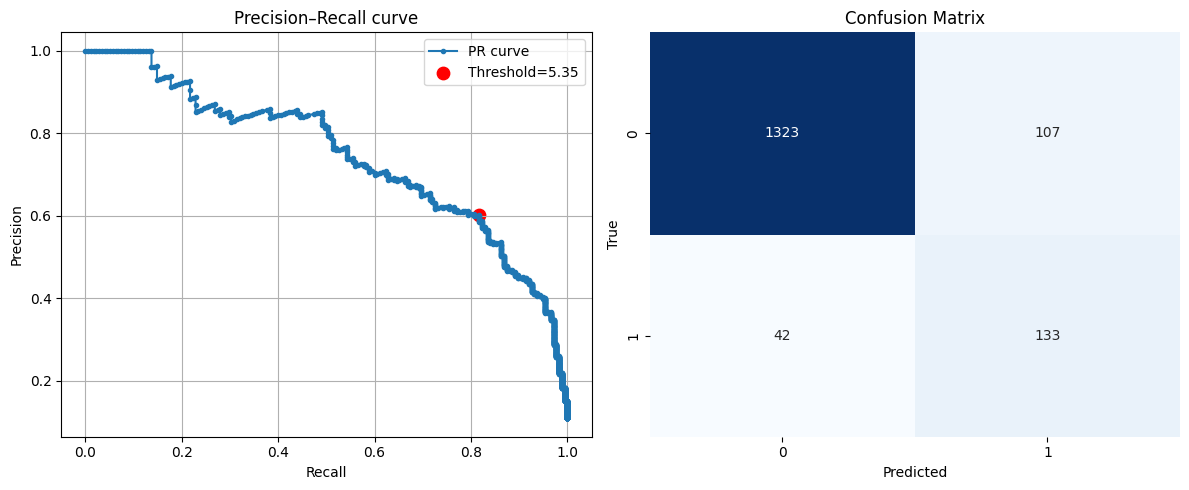

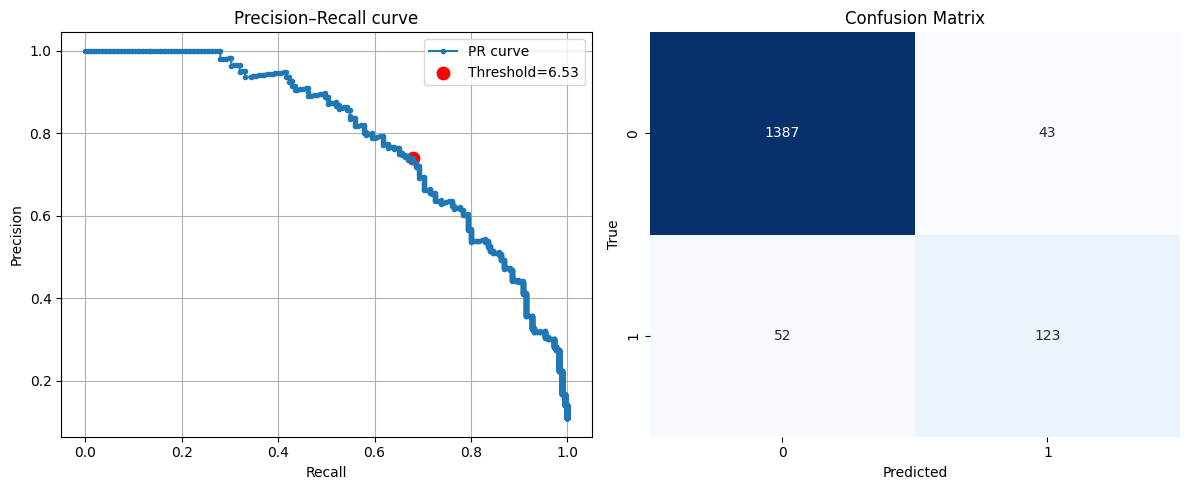

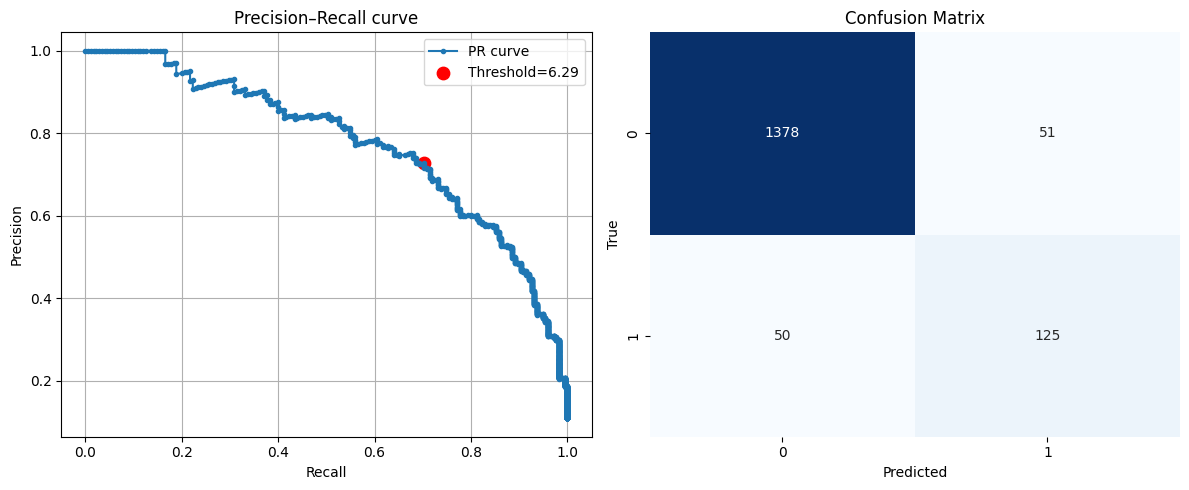

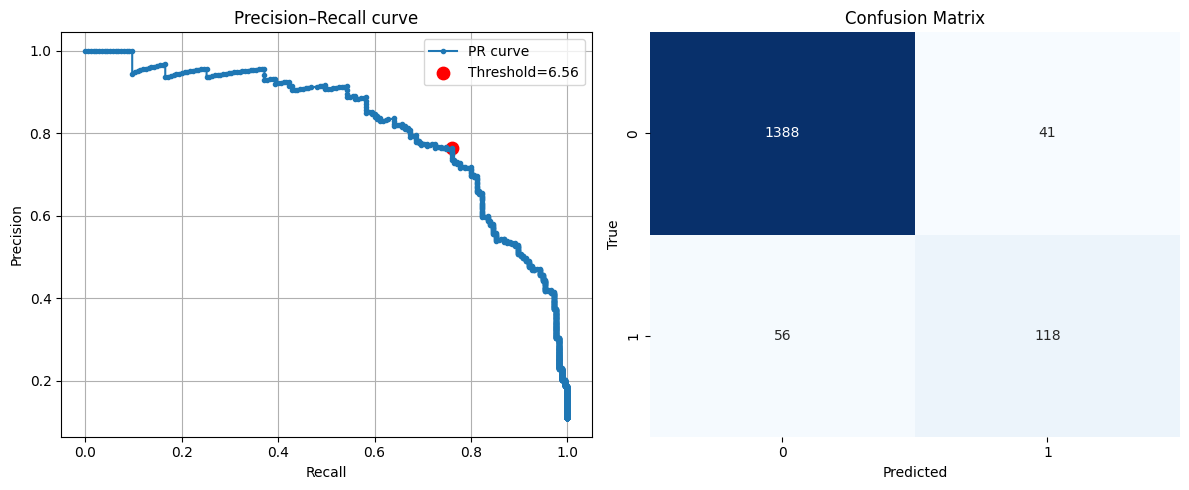

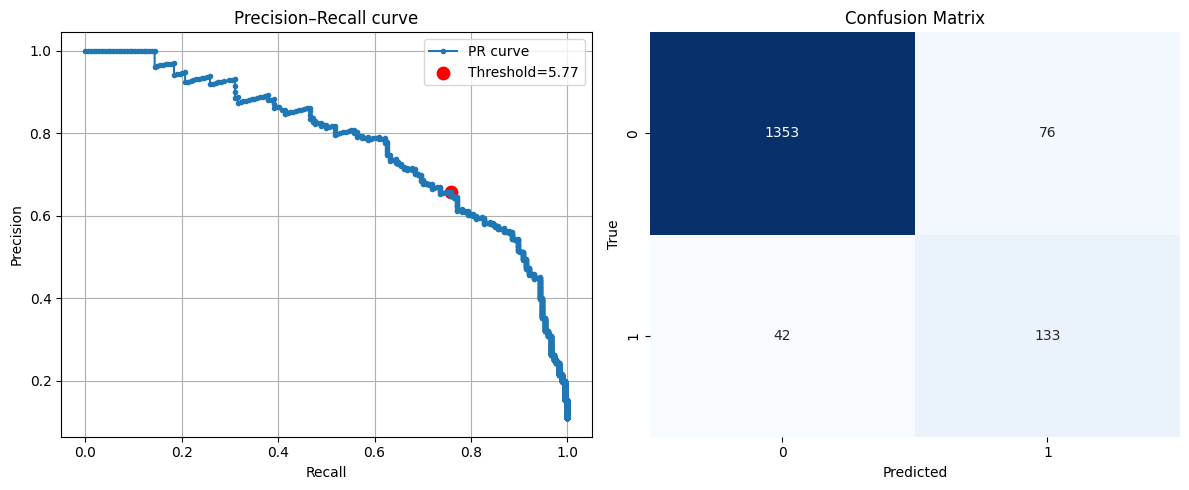

,MCC,ACC,PPV,SEN,threshold
0,0.658971,0.930186,0.676772,0.723061,6.1


In [ ]:
all_metrics = []
for key, value in groups.items():
    train, validation, test = value
    log_odds = training_vonHeijne(complete_train, train)
    optimal_threshold, validation_scores, y_validation = validation_vonHeijne(complete_train, validation, log_odds, aa_index)
    y_pred_test, obs_test = test_vonHeijne(complete_train, test, optimal_threshold, log_odds, aa_index)

    MCC, ACC, PPV, SEN, CONF = metrics(obs_test, y_pred_test)
    all_metrics.append([MCC, ACC, PPV, SEN, optimal_threshold])
    plot_pr_and_confusion(
    y_validation,
    validation_scores,
    obs_test,
    y_pred_test,
    optimal_threshold,
    labels=[0,1],
    run_id=key
    )
avg_metrics = np.mean(np.array(all_metrics), axis=0)
means = pd.DataFrame([avg_metrics], columns=['MCC', 'ACC', 'PPV', 'SEN', 'threshold'])
means